In [ ]:
vfrom tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
num_classes=10

In [ ]:
y1_train = to_categorical(y_train, num_classes)
y1_test = to_categorical(y_test, num_classes)

In [ ]:
traindata_generator=ImageDataGenerator(rescale=1./255,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2, horizontal_flip=True,validation_split=0.2)
validdata_generator=ImageDataGenerator(rescale=1./255)
testdata_generator=ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size=32
epochs=20

In [ ]:
def inceptionnet(x,filters):
    #(1x1) layer
    layer1=Conv2D(filters=filters[0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    #(3x3) layer
    layer2=Conv2D(filters=filters[1][0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    layer2=Conv2D(filters=filters[1][1],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer2)
    #(5x5) layer
    layer3=Conv2D(filters=filters[2][0],kernel_size=(5,5),strides=1,padding="same",activation="relu")(x)
    layers=Conv2D(filters=filters[2][1],kernel_size=(5,5),strides=1,padding="same",activation="relu")(layer3)
    layer4=MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(x)
    layer4=Conv2D(filters=filters[3],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer4)
    return Concatenate(axis=-1)([layer1,layer2,layer3,layer4])

In [ ]:
def helperfunction(x,name=None):
    layer=AveragePooling2D(pool_size=(3,3),strides=3,padding="valid")(x)
    layer=Conv2D(filters=128,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    layer=Flatten()(layer)
    layer=Dense(units=255,activation="relu")(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=10,activation="softmax",name=name)(layer)
    return layer

In [ ]:
def googlenet():
    #taking layer input
    inputlayer=Input(shape=(32,32,3))
    #layer_1
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=1,padding="same",activation="relu")(inputlayer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    layer=BatchNormalization()(layer)
    #layer_2
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding="same",activation="relu")(layer)
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    #layer_3
    layer=inceptionnet(layer,[64,(96,128),(16,32),32])
    layer=inceptionnet(layer,[128,(128,192),(32,96),64])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    #layer_4
    layer=inceptionnet(layer,[192,(96,208),(16,48),64])
    final_0=helperfunction(layer,name="final_layer_0")
    layer=inceptionnet(layer,[160,(112,224),(24,64),64])
    layer=inceptionnet(layer,[128,(128,256),(24,64),64])
    layer=inceptionnet(layer,[112,(144,288),(32,64),64])
    final_1=helperfunction(layer,name="final_layer_1")
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    #layer_5
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=inceptionnet(layer,[384,(192,384),(48,128),128])
    layer=AveragePooling2D(pool_size=(7,7),strides=1,padding="same")(layer)
    #layer_6
    layer=Flatten()(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=256,activation="linear")(layer)
    final_2=Dense(units=10,activation="softmax",name="final_layer_2")(layer)
    model=Model(inputs=inputlayer,outputs=[final_2,final_0,final_1])
    return model


In [ ]:
model=googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['max_pooling2d[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(1e-3),metrics=['acc'])

In [ ]:
model.fit(testdata_generator.flow(x_test,y1_test,batch_size=batch_size),epochs=epochs,shuffle=True)

Epoch 1/20
313/313 [==============================] - 30s 41ms/step - loss: 6.9044 - final_layer_2_loss: 2.3021 - final_layer_0_loss: 2.3006 - final_layer_1_loss: 2.3016 - final_layer_2_acc: 0.1141 - final_layer_0_acc: 0.1099 - final_layer_1_acc: 0.0979
Epoch 2/20
313/313 [==============================] - 9s 30ms/step - loss: 6.8971 - final_layer_2_loss: 2.3007 - final_layer_0_loss: 2.2954 - final_layer_1_loss: 2.3010 - final_layer_2_acc: 0.1128 - final_layer_0_acc: 0.1188 - final_layer_1_acc: 0.1018
Epoch 3/20
313/313 [==============================] - 9s 30ms/step - loss: 6.8889 - final_layer_2_loss: 2.2991 - final_layer_0_loss: 2.2901 - final_layer_1_loss: 2.2997 - final_layer_2_acc: 0.1173 - final_layer_0_acc: 0.1333 - final_layer_1_acc: 0.1070
Epoch 4/20
313/313 [==============================] - 10s 34ms/step - loss: 6.8785 - final_layer_2_loss: 2.2963 - final_layer_0_loss: 2.2842 - final_layer_1_loss: 2.2979 - final_layer_2_acc: 0.1229 - final_layer_0_acc: 0.1427 - final_layer_

In [ ]:
score=model.evaluate(x_test,y1_test,batch_size=batch_size,verbose=1)
print(score)

313/313 [==============================] - 4s 12ms/step - loss: 1076.0642 - final_layer_2_loss: 459.7213 - final_layer_0_loss: 262.1187 - final_layer_1_loss: 354.2243 - final_layer_2_acc: 0.1155 - final_layer_0_acc: 0.1368 - final_layer_1_acc: 0.1035
[1076.064208984375, 459.7213134765625, 262.11871337890625, 354.2242736816406, 0.11550000309944153, 0.13680000603199005, 0.10350000113248825]


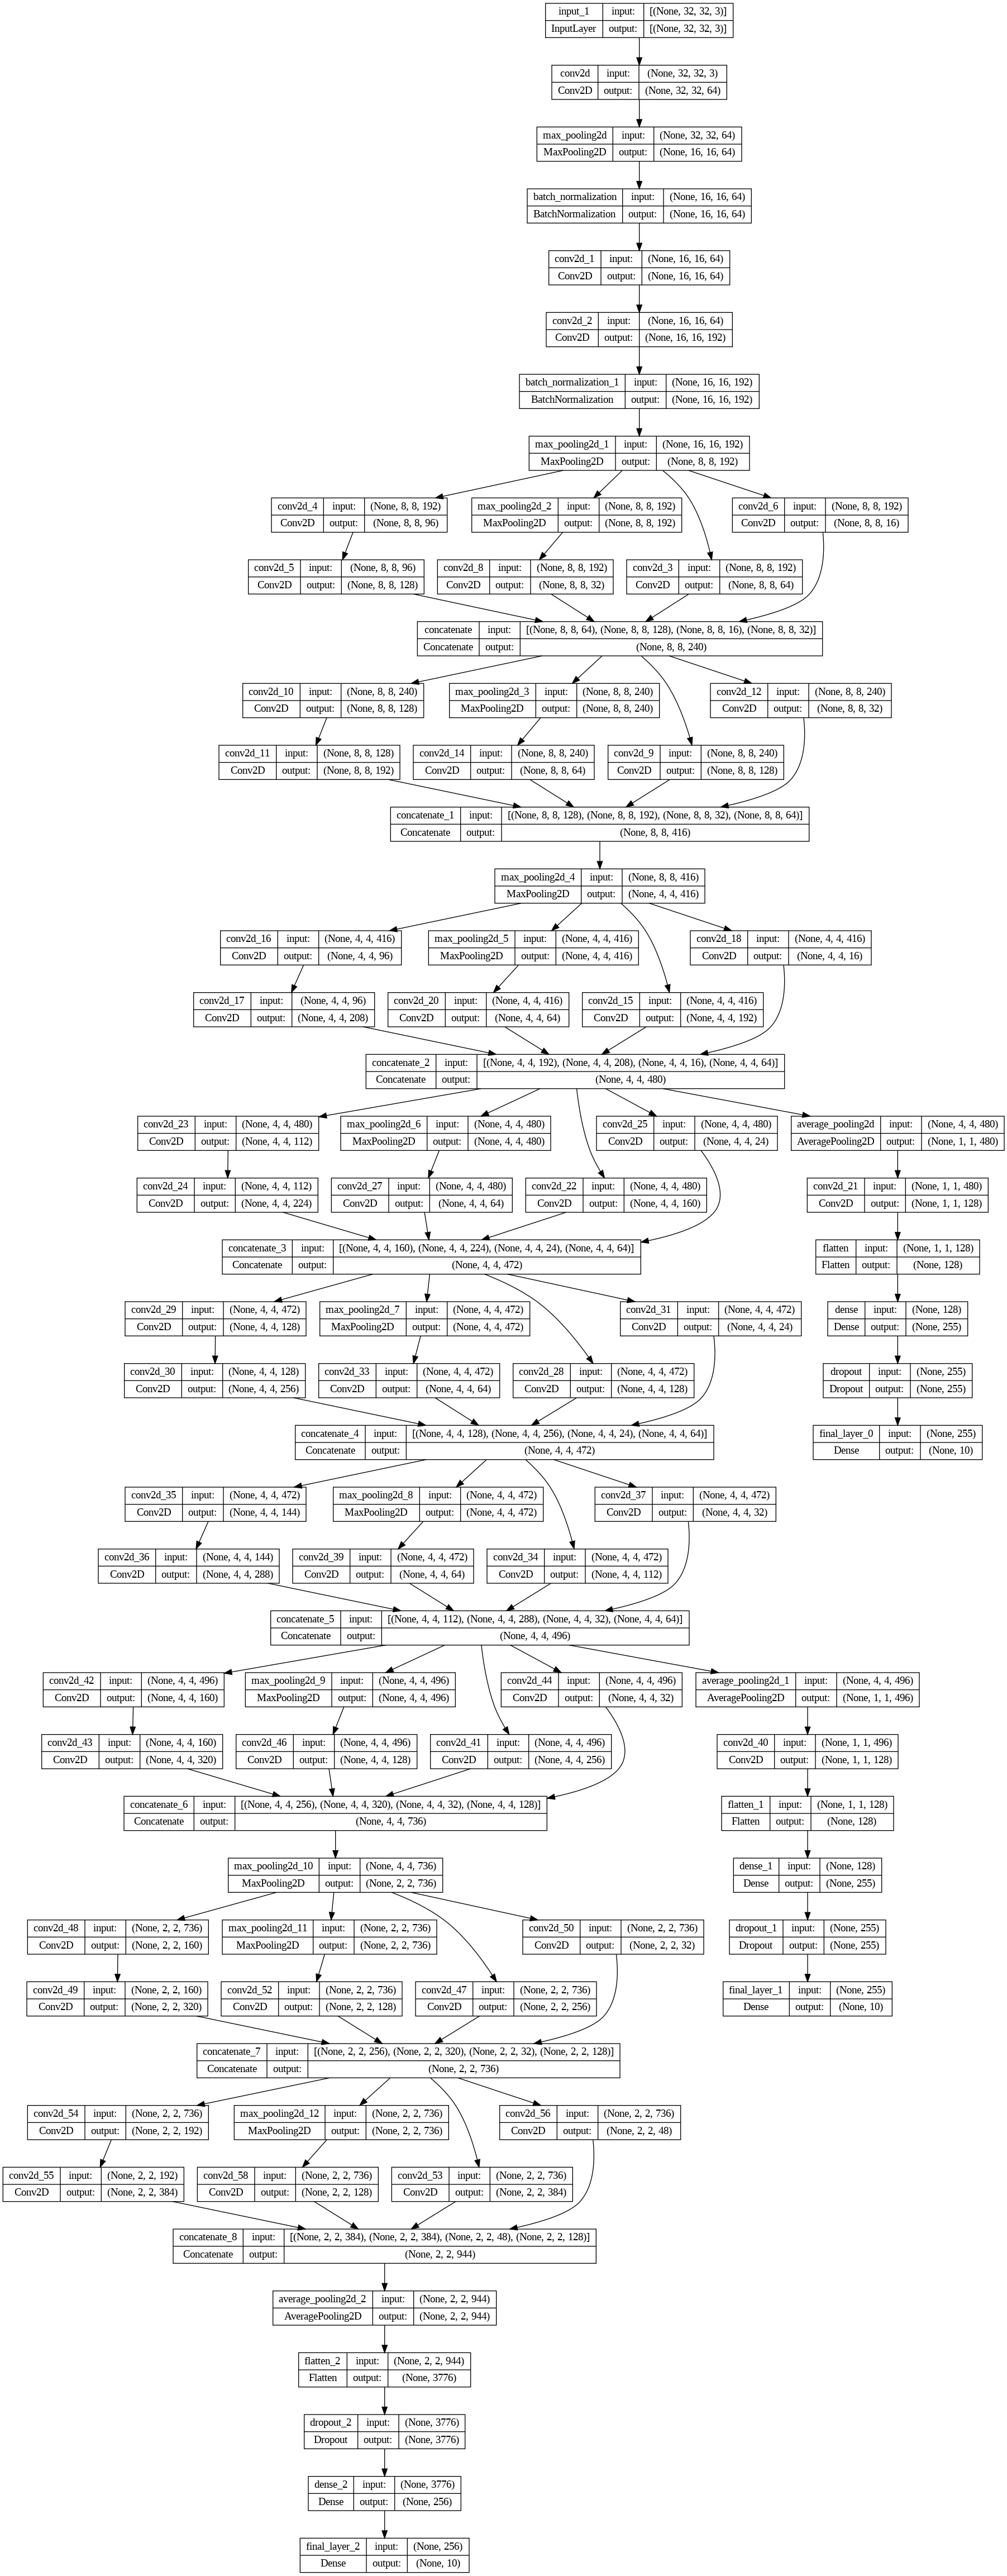

In [ ]:
plot_model(model,show_shapes=True)